# Weather Augmentation Visualizer Demo

Om Anavekar (oanaveka)<br>
Autonomous Driving S25<br>
3/2/2025<br>

### Libraries

In [1]:
import sys
import os

# Add the project root (parent directory) to sys.path
sys.path.append(os.path.abspath('..'))

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
from nuscenes.nuscenes import NuScenes
from augmentation.weather_augmentation import WeatherAugmentation
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_tensor
import random
import math

### Config

In [3]:
config = {
    'dataroot': '/scratch/nuscenes_v1-0_mini',
    'version': 'v1.0-mini',
    'rain_prob': 1.0,
    'snow_prob': 0.0,
    'fog_prob': 0.0,
    'rain_intensity': 10.0,
    'snow_intensity': 1.0,
    'fog_intensity': 1.0
}


In [4]:
# Set random seet
random.seed(42)

In [5]:
def show_transformation_result(original_img, transformed_img, figsize=(12, 8)):
    """
    Display the original and transformed images side by side using a grid.
    """
    # Convert PIL images to torch tensors
    orig_tensor = to_tensor(original_img)  # Shape: [C, H, W]
    trans_tensor = to_tensor(transformed_img)
    
    # Stack tensors to form a batch: shape [2, C, H, W]
    batch = torch.stack([orig_tensor, trans_tensor])
    
    # Create a grid; nrow=2 will display them side by side
    grid = make_grid(batch, nrow=2, padding=2)
    
    # Display the grid in the notebook
    plt.figure(figsize=figsize)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title("Original (Left) | Transformed (Right)")
    plt.show()


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.655 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


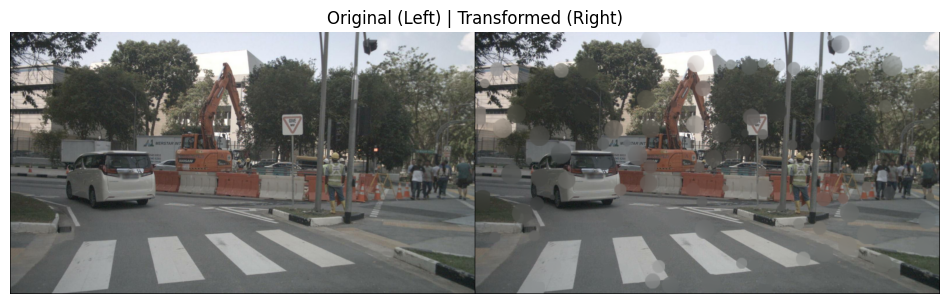

In [8]:

# Initialize nuScenes dataset
nusc = NuScenes(version=config['version'], dataroot=config['dataroot'], verbose=True)

# Get image from dataset
sample = nusc.sample[random.randint(0, 64)]
cam_token = sample['data']['CAM_FRONT']
img_path = nusc.get_sample_data_path(cam_token)
original_img = Image.open(img_path).convert('RGB')

# Transformation instance
weather_transform = WeatherAugmentation(rain_prob=config['rain_prob'], snow_prob=config['snow_prob'], fog_prob=config['fog_prob'],
                                        rain_intensity=config['rain_intensity'], snow_intensity=config['snow_intensity'], fog_intensity=config['fog_intensity'])

# Applied transformation
transformed_img = weather_transform(original_img)

show_transformation_result(original_img, transformed_img)